In [1]:
import warnings
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

warnings.filterwarnings("ignore")

#import sklearn
#sklearn.show_versions()
#sklearn.__version__
set_config(display='diagram')

In [2]:
data = pd.read_csv('data/train.csv', index_col=0)

In [3]:
data

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54
848831,1991-09-30 11:40:00,2,3,NE,28
848832,1991-09-30 11:40:00,2,3,SB,68


In [4]:

from sklearn.preprocessing import MinMaxScaler

def feature_generation(data):

    # add feature with number of na's per row + standard deviation
    features = [col for col in data.columns if 'f' in col] # if 'f' is in the name
    data['count_na'] = data[features].isna().sum(axis=1)

    features += ['count_na']

    # now do imputation with mean
    data[features] = data[features].fillna(data[features].mean())

    return data, features

scaler = MinMaxScaler()
#data, features = feature_generation(data)

#data[features] = scaler.fit_transform(data[features])


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
import lightgbm as lgb

# prepare the data
y = data.pop('congestion')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [11]:
pip install flaml

Note: you may need to restart the kernel to use updated packages.


In [12]:
from flaml import AutoML

automl = AutoML()

#mode="max"/"min"
automl.fit(X, y, metric="mse", task="regression", time_budget=3600*2, log_file_name="automl.log", n_jobs=-1)  # , ensemble= False, estimator_list=['lgbm', 'catboost', 'xgboost']
#automl.fit(X, y, metric="mse", task="regression", time_budget=3600*8, log_file_name="automl.log", n_jobs=1, eval_method='cv', n_splits=5, estimator_list=['lgbm']) #'xgboost', 'catboost', -- don't waste time with multiple algos

[flaml.automl: 03-21 21:54:16] {2068} INFO - task = regression
[flaml.automl: 03-21 21:54:16] {2070} INFO - Data split method: uniform
[flaml.automl: 03-21 21:54:16] {2074} INFO - Evaluation method: holdout
[flaml.automl: 03-21 21:54:16] {2155} INFO - Minimizing error metric: mse
[flaml.automl: 03-21 21:54:16] {2248} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 03-21 21:54:16] {2501} INFO - iteration 0, current learner lgbm


TypeError: generate_variants() takes 1 positional argument but 2 were given

In [22]:
#automl.best_estimator
automl.best_config
#0.1896 was best of prev run

#nu0.1863


{'n_estimators': 1518,
 'num_leaves': 19,
 'min_child_samples': 112,
 'learning_rate': 0.03489387357529748,
 'subsample': 0.9410633339183028,
 'log_max_bin': 7,
 'colsample_bytree': 0.738906888070166,
 'reg_alpha': 0.0026503387318717064,
 'reg_lambda': 0.31590573290271945}

In [23]:
test_data = pd.read_csv('data/test.csv', index_col=0)
test_data, _ = feature_generation(test_data)
test_data = pd.DataFrame(scaler.transform(test_data), columns=features, index=test_data.index)

# holdout_pred = automl.predict(test_data)
holdout_pred = automl.predict_proba(test_data)

test_data['claim'] = holdout_pred[:,1]
submission = test_data['claim']
submission.to_csv('data/holdout_predictions.csv')
#data_to_save.reset_index()
#data_to_save.to_csv('data/holdout_predictions.csv', index=False)

In [24]:
from flaml.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = get_output_from_log(filename='automl.log', time_budget=3600*8)

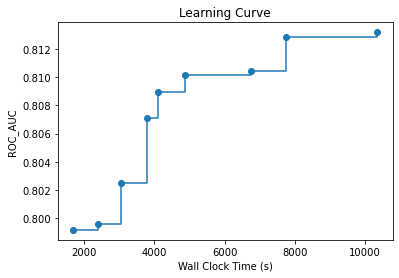

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('ROC_AUC')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [26]:
print("done!")

done!
